In [6]:
#importing libraries

import random as rd
import hashlib
import phe
import rsa
import matplotlib.pyplot as plt
import numpy as np
from timeit import default_timer as timer


In [7]:
#declaring of varibles
numberOfExperts = 0
numberOfCandidates = 0
keySize = 0
#collection of homomophic public and private keys
dictionaryOfExpertPublicKeys = {}
dictionaryOfExpertPrivateKeys = {}

dictionaryOfCandidatesPublicKeys = {}
dictionaryOfCandidatesPrivateKeys = {}

#Variables for third framework@
dictionaryOfRandomNumberPerExpert = {}
dictionaryOftheSumOfRandomNumbermappedToEveryCandidate = {}
dictionaryOfRandomNumberGatheredFromOtherExperts = {}
dictionaryOfRandomNumberMappedToEveryCandidate = {}

#Collection of rsa public and private keys for digital signature
dictOfrsaPubKey = {}
dictOfrsaPriKey = {}
marksToCandidates = []


In [8]:
def initVariables(E, C, key):
    global numberOfExperts, numberOfCandidates,keySize
    numberOfExperts, numberOfCandidates,keySize = E, C, key

In [9]:
#this part of the code create the public and private homomorphic key pairs
def generateHomomorphickeyPairs():
    global publicKeyEmployer,privateKeyEmployer
    publicKeyEmployer,privateKeyEmployer = phe.generate_paillier_keypair(n_length=keySize)
    for i in range(numberOfExperts):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfExpertPublicKeys[i] = x
        dictionaryOfExpertPrivateKeys[i] = y
        
    for i in range(numberOfCandidates):
        x,y = phe.generate_paillier_keypair(n_length=keySize)
        dictionaryOfCandidatesPublicKeys[i]= x
        dictionaryOfCandidatesPrivateKeys[i] = y 


In [10]:
#code to generate rsa public and private keys
def generateRSAKeys():
    global dictOfrsaPubKey, dicOfrsaPriKey
    for i in range(numberOfExperts):
        (pubkey, privkey) = rsa.newkeys(512)
        dictOfrsaPubKey[i],dictOfrsaPriKey[i] = pubkey, privkey 

In [11]:
# function to create digital signature
def createDigitalSignature(message,i):
    privkey = dictOfrsaPriKey[i]
    temp = str(message).encode()
    signature = rsa.sign(temp, privkey, 'SHA-1')
    return signature

In [12]:
def generateRandomNumberForEveryExpert():
    # global dictionaryOfRandomNumberPerExpert
    generatedRandomNumbers = [rd.randint(0,100) for x in range(numberOfExperts)]
    # print(generatedRandomNumbers)
    return generatedRandomNumbers
    # print(dictionaryOfSumGeneratedPerRandomNumber)

In [13]:
def forwardTheRespectiveRandomNumbers(idR,generatedRandomNumbers):
    encryptedRandomNumber = dictionaryOfExpertPublicKeys[idR].raw_encrypt(generatedRandomNumbers[idR])
    message = encryptedRandomNumber
    return message
# ,createDigitalSignature(encryptedRandomNumber,idS)

In [14]:
def performSMPCBetweenExperts():
    #this part of the code simulates the part where expert follow the smpc process
    #the random number assgned by all the experts has been mapped for every candidate
    
    for i in range(numberOfCandidates):
        matrixOfForwardedMessages = [[0 for i in range(numberOfExperts)] for j in range(numberOfExperts)]
        sumList = []
        for j in range(numberOfExperts):
            generatedRandomNumbers = generateRandomNumberForEveryExpert()
            sumOfTheRandomNumbers = sum(generatedRandomNumbers) 
            sumList.append(sumOfTheRandomNumbers)

            for k in range(numberOfExperts):
                if(j != k):
                    message = forwardTheRespectiveRandomNumbers(k,generatedRandomNumbers)
                    matrixOfForwardedMessages[j][k] = message
                else:
                    matrixOfForwardedMessages[j][k] = generatedRandomNumbers[j]
        dictionaryOfRandomNumberMappedToEveryCandidate[i] = matrixOfForwardedMessages
        dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i] = sumList
    # print(dictionaryOfRandomNumberMappedToEveryCandidate)
    # print(dictionaryOftheSumOfRandomNumbermappedToEveryCandidate)
    # print(dictionaryOfSumGeneratedPerRandomNumber)
    

    

In [15]:
def generateHiddenScoreFrameWork3():
    global marksToCandidates
    marksToCandidates = [[0 for i in range(numberOfCandidates)] for j in range(numberOfExperts)]
    for i in range(numberOfCandidates):
        for j in range(numberOfExperts):
            mark = rd.randint(0,100)
            hiddenScore = mark + dictionaryOftheSumOfRandomNumbermappedToEveryCandidate[i][j]
            sum  = 0
            for k in range(numberOfExperts):
                if(j != k):
                    encryptedRandomNumber = dictionaryOfRandomNumberMappedToEveryCandidate[i][k][j]
                    # print(encryptedRandomNumber)
                    sum  = sum + dictionaryOfExpertPrivateKeys[j].raw_decrypt(encryptedRandomNumber)
                else: 
                    sum = sum + dictionaryOfRandomNumberMappedToEveryCandidate[i][j][j]
            hiddenScore  = hiddenScore -sum
            # print(hiddenScore)
            marksToCandidates[j][i] = hiddenScore
            


In [16]:
def candidateManagerFrameWork3BestCandidate():
    array = []
    for i in range(numberOfCandidates):
        sum = 0
        for j in range(numberOfExperts):
            cummulativeScore = marksToCandidates[j][i]
            sum  = sum + cummulativeScore
        array.append(sum)
    # print(array)
    # print(array.index(max(array)))

In [17]:
def expertFunctionToGiveMarks():
    performSMPCBetweenExperts()
    generateHiddenScoreFrameWork3()

In [18]:
def runSimulation(experts,candidates,flag,keySize):
    experts = experts
    timeList = []
    candidates = candidates

    if flag == "candidates":
        for i in range(len(candidates)):
            start = timer()
            initVariables(experts,candidates[i],keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            expertFunctionToGiveMarks()
            candidateManagerFrameWork3BestCandidate()
            
            end = timer()
            timeList.append(end - start)
    else: 
        for i in range(len(experts)):
            start = timer()
            initVariables(experts[i],candidates,keySize)
            generateHomomorphickeyPairs()
            generateRSAKeys()
            expertFunctionToGiveMarks()
            candidateManagerFrameWork3BestCandidate()
            
            end = timer()
            timeList.append(end - start)
    # print(timeList)
    return (timeList)

In [19]:
#this part of the code run the simulation for defined number of times and helps us to calcuate average execution time
def averageTimeConsumedFunction(experts, candidates,flag,keySize):
    timeMatrix = []
    for i in range(0,20):
        timeList= runSimulation(experts, candidates,flag,keySize)
        timeMatrix.append(timeList)
    print(timeMatrix)        
    arr = np.array(timeMatrix, dtype='float32')
    print(arr)
    columns_average = arr.mean(axis=0)

    if flag == "candidates":
        plt.title("number of experts " + str(experts) + " and key size of " + str(keySize))
        plt.xlabel("number Of Candidates")
        plt.ylabel("Average Execution Time")   
        plt.bar(candidates, columns_average)
        plt.show()
    else :
        plt.title("number of candidates " + str(candidates) + " and key size of " + str(keySize))
        plt.xlabel("number Of Experts")
        plt.ylabel("Average Execution Time")   
        plt.bar(experts, columns_average)
        plt.show()
    
    return columns_average

        


In [20]:
def simulationHavingExpertsConstCandidatesVariable(experts, candidates,flag,keySize):
    column_average = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return candidates, column_average,experts
    

In [21]:
def simulationHavingExpertsvariableCandidatesConst(experts,candidates,flag,keySize):
    column_average = averageTimeConsumedFunction(experts,candidates,flag,keySize)
    return candidates,column_average,experts

[[0.06474316700041527, 0.20753869600230246, 0.17858820199762704, 0.36103823599842144, 0.4634875869996904], [0.09154506499908166, 0.11958709399914369, 0.17625808799857623, 0.38591073799761944, 0.342138783998962], [0.11150530300074024, 0.12185468099778518, 0.17975752699931036, 0.2578581640009361, 0.3670425329983118], [0.08249721500033047, 0.15083037600197713, 0.2726759540018975, 0.2606791730031546, 0.40267157700145617], [0.07915893200333812, 0.1888943849990028, 0.24636025600193534, 0.33995847099868115, 0.38823582099939813], [0.13555188199825352, 0.19754554600149277, 0.21500796499822172, 0.24102833400320378, 0.48314367300190497], [0.05378622300122515, 0.15781136999794398, 0.23322269399795914, 0.32096697199813207, 0.3759197809995385], [0.07709168299697922, 0.09131035400059773, 0.1956804209985421, 0.4425890279999294, 0.41456930999993347], [0.0581143500021426, 0.163933037998504, 0.17693210699871997, 0.2043850569971255, 0.3917966409971996], [0.07186623000234249, 0.106907270001102, 0.236939808

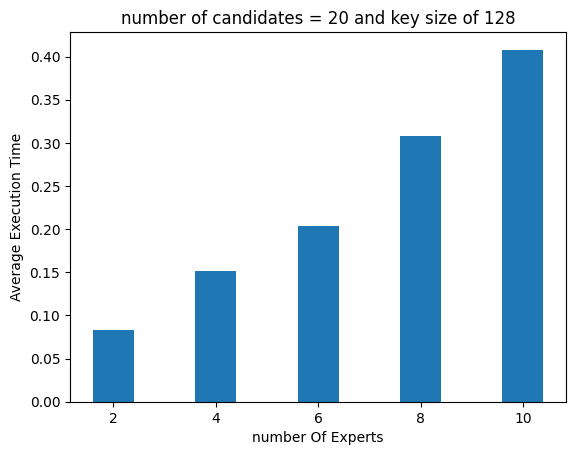

[[0.1714200799979153, 0.3152902810033993, 0.4029245149977214, 0.6137500240001827, 0.8982045249977091], [0.14791237700046622, 0.22082597400003579, 0.41723435099993367, 0.5468352229981974, 0.8103345849995094], [0.14502683300088393, 0.23096857099881163, 0.4417117010016227, 0.6909234310005559, 0.922551765001117], [0.13534377300311462, 0.23249593299988192, 0.38115847099834355, 0.61557104700114, 0.9078529910002544], [0.1335004120010126, 0.2811288760021853, 0.39782876599929295, 0.547736091997649, 0.8818794489998254], [0.10213279800154851, 0.30695892800213187, 0.4238105490003363, 0.5200044040029752, 0.8524115569998685], [0.11723578199962503, 0.2532887609995669, 0.4399027510007727, 0.6635897470005148, 0.8489785919991846], [0.10844165799790062, 0.22570015599922044, 0.43521081400103867, 0.5689911689987639, 0.9221415600004548], [0.13263622699741973, 0.3491344879985263, 0.3752482290001353, 0.6375047010005801, 0.9033509260007122], [0.1307442750003247, 0.2683125130024564, 0.4811752749992593, 0.594946

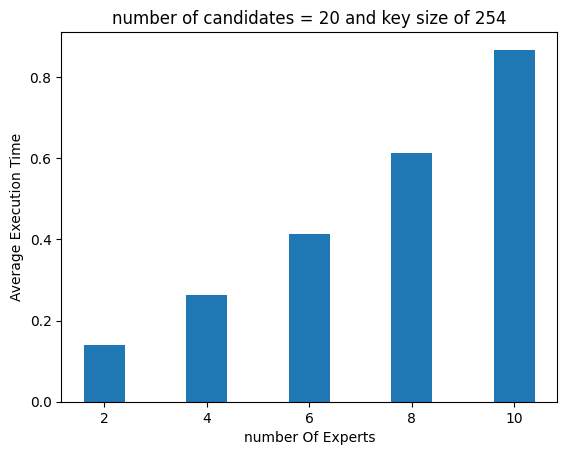

[[0.4426493520004442, 0.7073350090031454, 1.4061862479975389, 2.489232855998125, 3.516902545998164], [0.34066889899986563, 0.8832281110007898, 1.4950747850016342, 2.2957514019981318, 3.5316845060006017], [0.5484197629994014, 0.7980894520005677, 1.4629528090008534, 2.4833791499986546, 3.6296260100025393], [0.4485442980003427, 0.8112295890023233, 1.450177945996984, 2.476323514998512, 3.5601599879992136], [0.47031290599989006, 0.7490591790010512, 1.5683484330002102, 2.3952928819999215, 3.7496635720017366], [0.43937397099944064, 0.8458652459994482, 1.420480046999728, 2.4202783109976735, 3.471979496000131], [0.46001164900008007, 0.9221567249987856, 1.4706005090010876, 2.479471812999691, 3.5933507260015176], [0.3980869299994083, 0.8128662839990284, 1.434305659000529, 2.4404650760006916, 3.6032129199993506], [0.4388356890012801, 0.796070428998064, 1.419984858999669, 2.3947034609991533, 3.6251873939982033], [0.4175526609978988, 0.8500704299985955, 1.459343014001206, 2.484200355000212, 3.723307

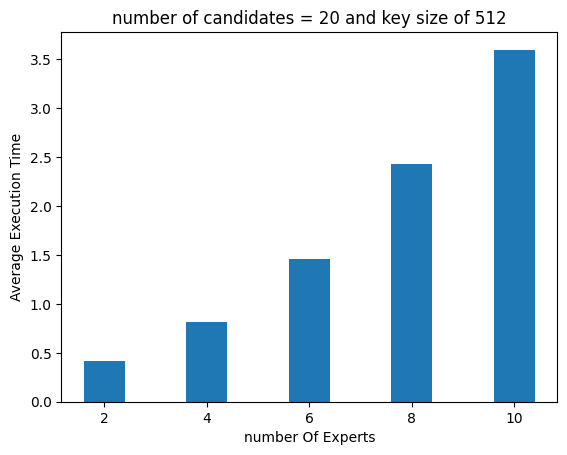

In [48]:
keys = [128,256,512]
for i in range(0,3):
    simulationHavingExpertsvariableCandidatesConst([2,4,6,8,10],20,"experts",keys[i])

[[0.15881682400140562, 0.2114731629990274, 0.2237946089990146, 0.19527023499904317, 0.27159701100026723], [0.13606235200131778, 0.24962465799762867, 0.1974547630015877, 0.22017122599936556, 0.31311632100187126], [0.19847994200245012, 0.17032120799922268, 0.19203428599939798, 0.23284042600062094, 0.2358360990001529], [0.16138716999921598, 0.26528087399856304, 0.19182204399839975, 0.26022332800130243, 0.2645682849979494], [0.1294202579992998, 0.18669232799948077, 0.26565155500065885, 0.2601802270000917, 0.2948789010006294], [0.09968577399922651, 0.19863661999988835, 0.16637433900177712, 0.23563088800074183, 0.2717169630013814], [0.1903215829988767, 0.1691343999991659, 0.2651091850020748, 0.21880909399988013, 0.2696938939989195], [0.14381777800008422, 0.18615380799747072, 0.19202452399986214, 0.21652589500081376, 0.30985005800175713], [0.14003438600047957, 0.13915545199779444, 0.18401663500117138, 0.23975757099833572, 0.27925217599840835], [0.15089698899828363, 0.1623788049982977, 0.30313

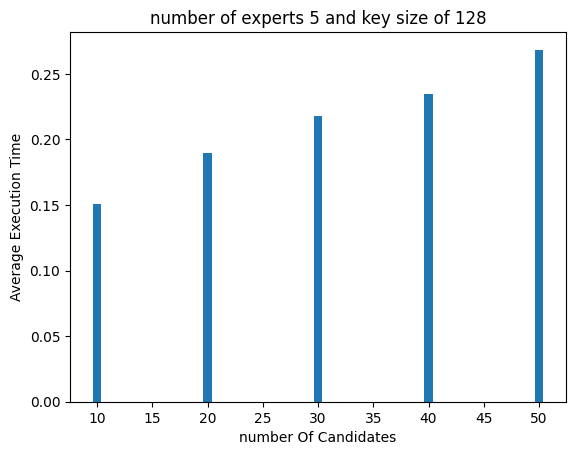

[[0.2137667019997025, 0.45069874199907645, 0.4092268909989798, 0.5221671170002082, 0.6044566210002813], [0.1799696629968821, 0.38046817899885355, 0.528784910999093, 0.599892081998405, 0.5989812789994176], [0.22066445999735151, 0.29118519900293904, 0.47191862299951026, 0.5841754659995786, 0.6544627479997871], [0.23173735100135673, 0.3642866949994641, 0.4294553569998243, 0.49179955599902314, 0.6070921220016317], [0.25018000999989454, 0.38817903499875683, 0.44968706500003464, 0.5449280180000642, 0.6469382430004771], [0.19587509199845954, 0.44475242299813544, 0.4953136820004147, 0.48346580999714206, 0.5576506830002472], [0.23374738200072898, 0.3081660780007951, 0.5546300850000989, 0.616347355000471, 0.6215478510021057], [0.23471290499946917, 0.40267870699972264, 0.38133996599935926, 0.5236193620003178, 0.6245043870003428], [0.31026167399977567, 0.33500941899910686, 0.40314838999984204, 0.548523417000979, 0.6721409950005182], [0.2581544179993216, 0.33847709800102166, 0.49026376899928437, 0.

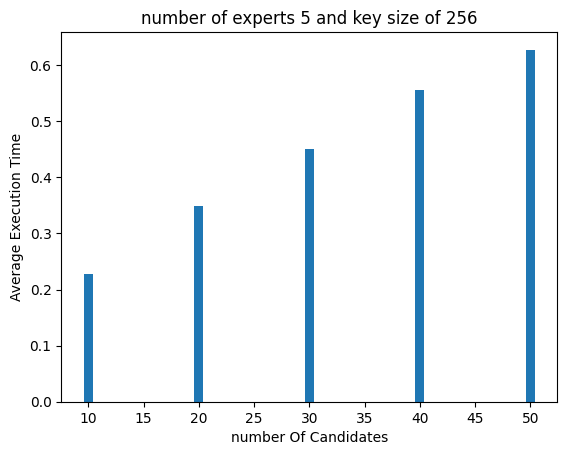

[[0.7714482240007783, 1.0379490790001, 1.4685256669981754, 2.0841730249994725, 2.601400442999875], [0.7536448549981287, 1.1080287110016798, 1.6150980689999415, 2.03084050599864, 2.69004040100117], [0.6615527260000817, 1.094937089997984, 1.636484331000247, 1.9398092419978639, 2.46647054999994], [0.7059654189979483, 1.1263341859994398, 1.6094011770001089, 2.025099873000727, 2.577948648999154], [0.7141581420000875, 1.1376617220012122, 1.54482975800056, 2.172281326002121, 2.7397304869991785], [0.6956065779995697, 1.1612582130001101, 1.5668410290018073, 2.155997395999293, 2.603558274000534], [0.7777651779979351, 1.2028031659974658, 1.506977144999837, 2.002378780001891, 2.378742945002159], [0.7438173930022458, 1.1460889109985146, 1.5469883939986175, 2.125343071998941, 2.5339535430030082], [0.6835060409975995, 1.1693973850015027, 1.7139615369997045, 1.9768393550002656, 2.601304314001027], [0.8162351379978645, 1.1729033829979016, 1.5420382080010313, 2.1862811489991145, 2.6599639630003367], [0.

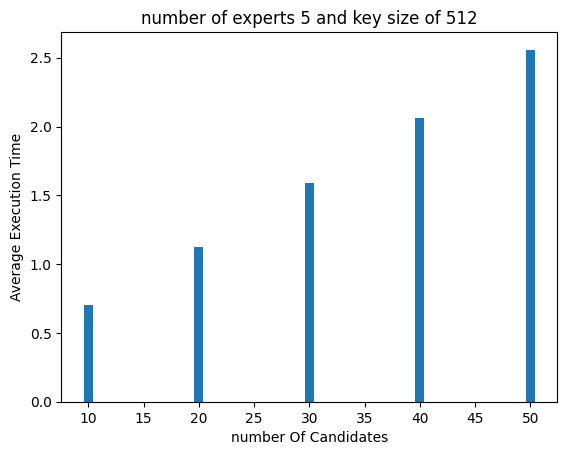

In [49]:
keys = [128,256,512]
for i in range(0,3):
    simulationHavingExpertsConstCandidatesVariable(5,[10,20,30,40,50],"candidates",keys[i])


[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]


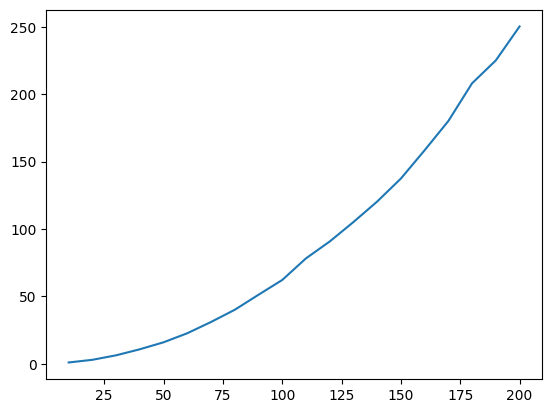

In [27]:
z = 10
timelist = []
expertlist = [z + (i * 10) for i  in range(0,20)]
print(expertlist)
timelist = runSimulation(expertlist,20,"experts",256)
plt.plot(expertlist,timelist)
